In [1]:
import torch
from torchvision.io import read_image, ImageReadMode
import torchvision.transforms as T
from random import randint
from IPython.display import clear_output

import numpy as np
import pylab as pl

from src import *

In [2]:
N_CHANNELS = 15        # Number of CA state channels
TARGET_PADDING = 8     # Number of pixels used to pad the target image border
TARGET_SIZE = 40       # Size of the target emoji
IMAGE_SIZE = TARGET_PADDING+TARGET_SIZE
BATCH_SIZE = 4
POOL_SIZE = 512
CELL_FIRE_RATE = 0.5

torch.backends.cudnn.benchmark = True # Speeds up things

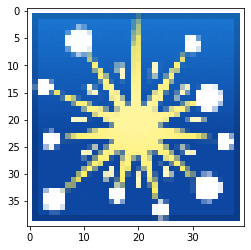

In [3]:
# Imports the target emoji
target = read_image("images/firework.png", ImageReadMode.RGB_ALPHA).float()
target = T.Resize((TARGET_SIZE, TARGET_SIZE))(target)
target = RGBAtoFloat(target)

imshow(target)

In [4]:
# Define the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
target = target.to(device)

model = MultipleCA(N_CHANNELS, n_CAs=2, device=device)

In [5]:
model.CAs[0].load("Pretrained_models/multiple_CA/multiple_CA_growing.pt")

checkpoint = torch.load("280_epoch_fisso.pt")
model.CAs[1].load_state_dict(checkpoint["state_dict"])
# model.losses = checkpoint["loss"]

Successfully loaded model!


<All keys matched successfully>

In [6]:
for param in model.CAs[0].parameters():
    param.requires_grad = False

generator = VirusGenerator(N_CHANNELS, IMAGE_SIZE, 2, model, virus_rate=0.9)
pool = SamplePool(POOL_SIZE, generator)

In [7]:
params = model.CAs[1].parameters()
target = pad(target, TARGET_PADDING)

optimizer = torch.optim.Adam(params, lr=2e-3)
# optimizer.load_state_dict(checkpoint["optimizer"])
criterion = NCALoss(target, torch.nn.MSELoss, alpha_channels=[15, 16])
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40,80], gamma=0.3)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 3e-4, 2e-3, 20, cycle_momentum=False)
# scheduler.load_state_dict(checkpoint["scheduler"])

model.train_CA(optimizer, criterion, pool, n_epochs=300, skip_update=1, batch_size=6,
               scheduler=scheduler, kind="persistent", skip_damage=1, n_max_losses=3,
               evolution_iters=(40, 45))

epoch: 42
avg loss: 0.037610619580921004


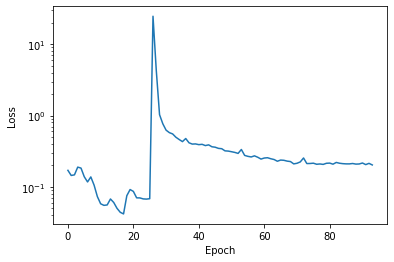

In [8]:
pl.plot(model.losses)
pl.xlabel("Epoch")
pl.ylabel("Loss")
pl.yscale("log")
pl.show()
# pl.savefig(fname="perturbation_regeneration_l=1_side=20_losses.png", dpi=200)

In [9]:
checkpoint = {
    "state_dict": model.CAs[1].state_dict(),
    "optimizer": optimizer.state_dict(),
    "scheduler": scheduler.state_dict(),
    "loss": model.losses
}

torch.save(checkpoint, "290_epoch_fisso.pt")

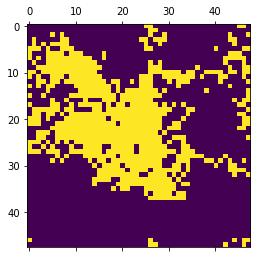

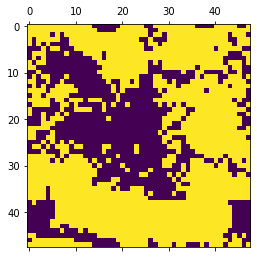

In [22]:
pl.matshow(inputs[0, -1].cpu()>0.1)
pl.matshow(inputs[0, -2].cpu()>0.1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


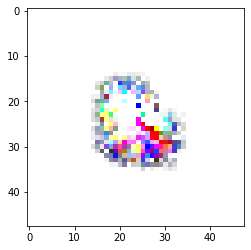

In [19]:
inputs = pool.sample(1)[0].detach().cuda()

imshow(state_to_image(inputs, [-1, -2])[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


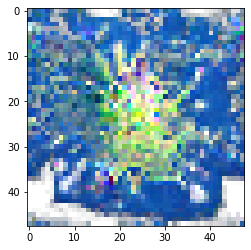

In [21]:
def state_to_image(x, mask_channels):
    alpha = x[:, mask_channels].sum(dim=1).unsqueeze(1)
    return torch.cat((x[:, :3], alpha), dim=1)

# recursive forward-pass
inputs = model.evolve(inputs, 40)

imshow(state_to_image(inputs, [-1, -2])[0])

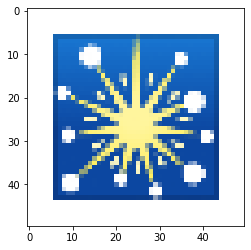

In [21]:
# Plots the true emoji
imshow(TraintoFloat(pad(target, 10, -1)))